In [2]:
source('/home/akananth/Misc/Research-Jam-2023/effect_estimate_helper.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [7]:
df = fread('data/final_samples/final_regression_data.tsv', sep='\t') %>%
    mutate(created_date = as.Date(created_utc/60/60/24, origin='1970-01-01'), 
           subreddit_date = paste(subreddit, created_date))
nrow(df)

[1] 16893013

# Banned Subreddits

In [4]:
banned_subreddits = fread('data/subreddit-info/banned_subreddits_utc.txt')
names(banned_subreddits) = c('subreddit','banned_utc','banned_date')
banned_subreddits <- banned_subreddits %>% 
    mutate(banned_date = as.Date(banned_date)) %>%
    filter(year(banned_date) >= 2019, year(banned_date) <= 2022)
nrow(banned_subreddits)
head(banned_subreddits)

Warning message in fread("data/subreddit-info/banned_subreddits_utc.txt"):
“Previous fread() session was not cleaned up properly. Cleaned up ok at the beginning of this fread() call.”


[1] 59719

subreddit,banned_utc,banned_date
<chr>,<int>,<date>
TradeNudePicsnVids,1559349142,2019-06-01
tacp,1559358198,2019-06-01
InDepthDickRating,1559402298,2019-06-01
OpieandAnthonyxyz,1559428750,2019-06-01
CumToKiernan,1559369897,2019-06-01
bruhfunny,1559429725,2019-06-01


# Comments from Banned Subreddits

In [8]:
#All Comments
banned_comments = df %>% filter(subreddit %in% banned_subreddits$subreddit)
nrow(banned_comments)

[1] 148277

In [9]:
#Comments 3 months before banning
month_before_banned <- banned_comments %>% 
    left_join(banned_subreddits, by='subreddit') %>%
    filter(banned_utc - created_utc <= 60 * 60 * 24 * 30 * 3 & author != '[deleted]') %>%
    mutate(type = 'Banned', timing='Before Ban') %>%
    unique
nrow(month_before_banned)

[1] 41647

In [10]:
length(unique(month_before_banned$subreddit)) # number of banned subreddits in sample

[1] 1709

# Comparison Comments

In [6]:
# Comments from other subreddits by users from banned subreddits
banned_users = df %>% 
    filter(author %in% unique(month_before_banned$author),
           !comment_id %in% month_before_banned$comment_id)
nrow(banned_users)

[1] 162915

In [7]:
# Users from the banned community migrating to other subreddits
migrated <- banned_users %>% 
    inner_join(month_before_banned %>% dplyr::select(author,banned_utc), by='author') %>%
    filter(banned == 0 &
           first_post_utc > banned_utc & 
           first_post_utc - banned_utc < 60 * 60 * 24 * 30 * 3) %>%
    mutate(type = 'Banned', timing='After Ban') %>%
    unique
nrow(migrated)

[1] 15849

In [28]:
# Users from the banned community posting in other subreddits at the same time 
banned_users_elsewhere <- banned_users %>% 
    inner_join(month_before_banned %>% 
               dplyr::select(author,banned_subreddit=subreddit,banned_utc), by='author') %>%
    filter(banned == 0 & abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * 3) %>%
    group_by(subreddit, author) %>%
    mutate(first_post_utc = min(created_utc),
           last_post_utc = max(created_utc)) %>%
    ungroup() %>%
    filter(first_post_utc < banned_utc &
           last_post_utc > banned_utc) %>%
    mutate(type = 'Elsewhere',
           timing = ifelse(banned_utc < created_utc, 'After Ban', 'Before Ban')) %>%
    filter(!duplicated(comment_id))
           
nrow(banned_users_elsewhere)

[1] 27332

In [43]:
# Users posting in the same subreddit who weren't in the banned community
non_banned_users_elsewhere <- df %>%
    filter(banned == 0,
           !author %in% unique(month_before_banned$author),
           subreddit_date %in% unique(banned_users_elsewhere$subreddit_date)) %>%
    inner_join(banned_users_elsewhere %>% dplyr::select(subreddit_date, timing, match_id=comment_id, 
                                                        match_utc=created_utc), by = 'subreddit_date') %>%
    mutate(match_diff = abs(match_utc-created_utc)) %>%
    group_by(match_id) %>%
    filter(match_diff == min(match_diff)) %>%
    mutate(type = 'Control')  %>%
    filter(!duplicated(match_id))

nrow(non_banned_users_elsewhere)

[1] 25503

Make sure we're looking at users who posted before and after the ban

In [44]:
banned_users_elsewhere <- banned_users_elsewhere %>% filter(comment_id %in% non_banned_users_elsewhere$match_id)
nrow(banned_users_elsewhere)

[1] 25503

In [71]:
n = c('num_markers', 'parent_num_markers', 'formality', 'parent_formality', 'timing', 'type',
      'depth', 'num_tokens', 'parent_num_tokens', 'subreddit_re')
m <- c()
b <- c()
lo <- c()
hi <- c()
p <- c()
for(x in c(0.5,1,1.5,2,2.5,3)){
    sub1 = banned_users_elsewhere %>% 
            filter(abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * x)
    sub2 = non_banned_users_elsewhere %>% 
            filter(match_id %in% sub1$comment_id)
    sub1 = sub1 %>% 
            filter(comment_id %in% sub2$match_id)
    message(paste(Sys.time(),x,nrow(sub1),nrow(sub2)))

    sub <- rbind(sub1[,n], sub2[,n]) %>% 
                group_by(author) %>%
                mutate(author_re = ifelse(n()<7,'Other',author)) %>% ungroup() %>%
                mutate(style = scale(num_markers),
                       parent_style = scale(parent_num_markers))

    mod <- lm(style ~ parent_style * type + 
                num_tokens + parent_num_tokens + depth, 
            sub %>% filter(timing == 'Before Ban'))
    ci1 <- confint(mod)
    ci1 <- ci1[nrow(ci1),]
    m <- c(m, -x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci1[1]))
    hi <- c(hi, unlist(ci1[2]))

    mod <- lm(style ~ parent_style * type + 
                    num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'After Ban'))
    ci2 <- confint(mod)
    ci2 <- ci2[nrow(ci2),]
    m <- c(m, x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci2[1]))
    hi <- c(hi, unlist(ci2[2]))
    
    p <- c(p, ifelse(ci1[2]<ci2[1], 1, ifelse(ci2[2]<ci1[1], -1, 0)))
    p <- c(p, ifelse(ci1[2]<ci2[1], -1, ifelse(ci2[2]<ci1[1], 1, 0)))

}
func_df = data.frame(time=m, LSM=b, lo=lo, hi=hi, significance=p)
fwrite(func_df, paste0(data_dir,'function_banned_elsewhere.csv'), row.names=F)

2023-06-15 18:01:18 0.5 8018 8018

2023-06-15 18:01:21 1 13444 13444

2023-06-15 18:01:25 1.5 17359 17359

2023-06-15 18:01:32 2 20679 20679

2023-06-15 18:01:37 2.5 23181 23181

2023-06-15 18:01:45 3 25503 25503



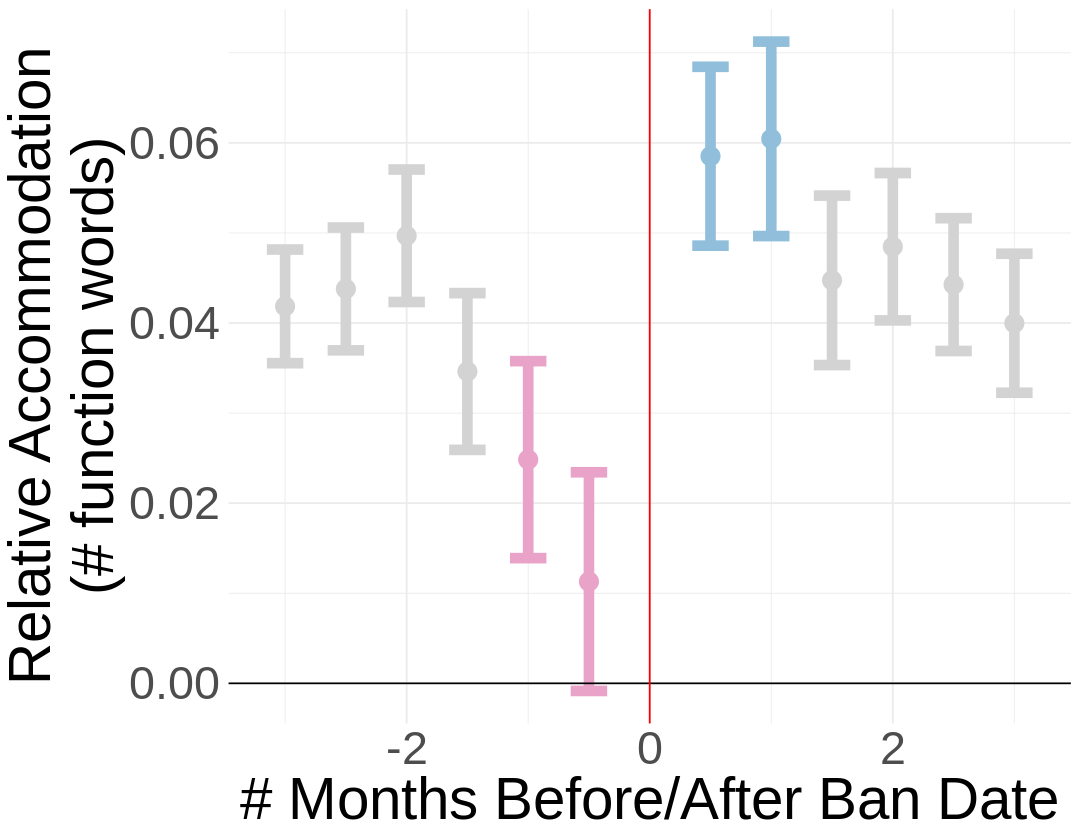

In [72]:
func_df = fread(paste0(data_dir,'function_banned_elsewhere.csv'))
options(repr.plot.width = 9, repr.plot.height = 7)
ggplot(func_df, aes(x = time, y = LSM, ymin = lo, ymax = hi, 
                    color=factor(significance)
                   )) +
    geom_point(size = 5) +
    geom_errorbar(size = 3, width = 0.3) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0, color='red') +
    scale_color_manual(values = c('#91bfdb','lightgrey','#e9a3c9')) +
    labs(x='# Months Before/After Ban Date', y='Relative Accommodation\n(# function words)') +
    theme_minimal() +
    theme(legend.position='none',
          text = element_text(size=35))
ggsave(paste0(plot_dir,'function_banned_elsewhere.pdf'), width = 9, height = 7)

In [73]:
n = c('num_markers', 'parent_num_markers', 'formality', 'parent_formality', 'timing', 'type',
      'depth', 'num_tokens', 'parent_num_tokens', 'subreddit_re')
m <- c()
b <- c()
lo <- c()
hi <- c()
p <- c()
for(x in c(0.5,1,1.5,2,2.5,3)){
    sub1 = banned_users_elsewhere %>% 
            filter(abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * x)
    sub2 = non_banned_users_elsewhere %>% 
            filter(match_id %in% sub1$comment_id)
    sub1 = sub1 %>% 
            filter(comment_id %in% sub2$match_id)
    message(paste(Sys.time(),x,nrow(sub1),nrow(sub2)))
    
    sub <- rbind(sub1[,n], sub2[,n]) %>% 
                group_by(author) %>%
                mutate(author_re = ifelse(n()<7,'Other',author)) %>% ungroup() %>%
                mutate(style = formality,
                       parent_style = parent_formality)

    mod <- lm(style ~ parent_style * type + 
                    num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'Before Ban'))
    ci1 <- confint(mod)
    ci1 <- ci1[nrow(ci1),]
    m <- c(m, -x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci1[1]))
    hi <- c(hi, unlist(ci1[2]))

    mod <- lm(style ~ parent_style * type + 
                    num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'After Ban'))
    ci2 <- confint(mod)
    ci2 <- ci2[nrow(ci2),]
    m <- c(m, x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci2[1]))
    hi <- c(hi, unlist(ci2[2]))
    
    p <- c(p, ifelse(ci1[2]<ci2[1], 1, ifelse(ci2[2]<ci1[1], -1, 0)))
    p <- c(p, ifelse(ci1[2]<ci2[1], -1, ifelse(ci2[2]<ci1[1], 1, 0)))
}
form_df = data.frame(time=m, LSM=b, lo=lo, hi=hi, significance=p)
fwrite(form_df, paste0(data_dir,'formality_banned_elsewhere.csv'), row.names=F)

2023-06-15 18:01:47 0.5 8018 8018

2023-06-15 18:01:49 1 13444 13444

2023-06-15 18:01:58 1.5 17359 17359

2023-06-15 18:02:02 2 20679 20679

2023-06-15 18:02:09 2.5 23181 23181

2023-06-15 18:02:13 3 25503 25503



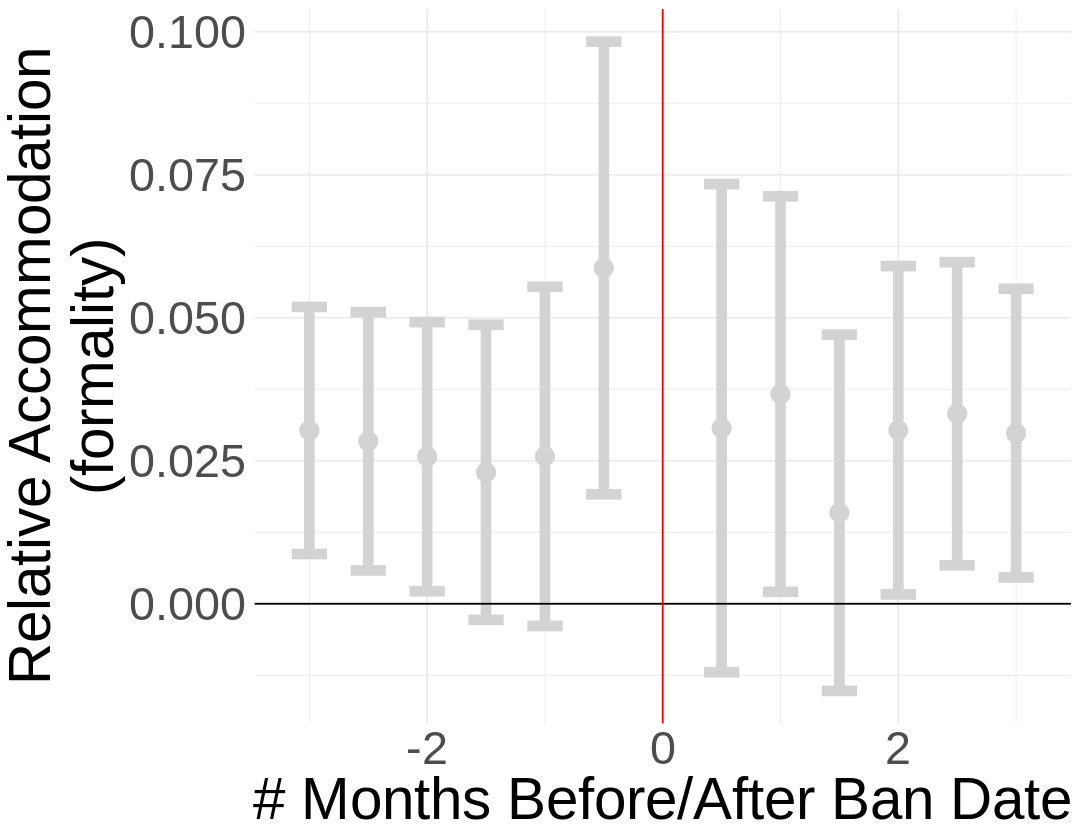

In [79]:
form_df = fread(paste0(data_dir,'formality_banned_elsewhere.csv'))
options(repr.plot.width = 9, repr.plot.height = 7)
ggplot(form_df, aes(x = time, y = LSM, ymin = lo, ymax = hi
                    , color = factor(significance)
                   )) +
    geom_point(size = 5) +
    geom_errorbar(size = 3, width = 0.3) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0, color='red') +
    #scale_color_manual(values = c('#91bfdb','lightgrey','#e9a3c9')) +
    scale_color_manual(values = 'lightgrey') +
    labs(x='# Months Before/After Ban Date', y='Relative Accommodation\n(formality)') +
    theme_minimal() +
    theme(legend.position='none',
          text = element_text(size=35))
ggsave(paste0(plot_dir,'formality_banned_elsewhere.pdf'), width = 9, height = 7)

In [ ]:
x = 1
sub1 = banned_users_elsewhere %>%
        filter(abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * x)
sub2 = non_banned_users_elsewhere %>% 
        filter(match_id %in% sub1$comment_id)
sub1 = sub1 %>% 
        filter(comment_id %in% sub2$match_id)
sub <- rbind(sub1[,n], sub2[,n])
sub$style <- sub$formality
sub$parent_style <- sub$parent_formality

mod <- lmer(style ~ parent_style * type * timing + 
                num_tokens + parent_num_tokens + depth + (1|subreddit_re), 
            sub %>% mutate(timing = relevel(factor(timing), 'Before Ban')))
summary(mod)

In [67]:
n = c('num_markers', 'parent_num_markers', 'formality', 'parent_formality', 'timing', 'type',
      'depth', 'num_tokens', 'parent_num_tokens', 'subreddit','author')
m <- c()
b <- c()
lo <- c()
hi <- c()
p <- c()
for(x in c(0.5,1,1.5,2,2.5,3)){
    sub1 = month_before_banned %>% 
            filter(banned_utc - created_utc <= 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub2 = migrated %>% 
            filter(author %in% sub1$author, 
                   abs(first_post_utc - banned_utc) < 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub1 = sub1 %>% filter(author %in% sub2$author)
    sub3 = banned_users_elsewhere %>% 
            filter(author %in% sub1$author,
                   abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub1 = sub1 %>% filter(author %in% sub3$author)
    sub2 = sub2 %>% filter(author %in% sub1$author)
    message(paste(Sys.time(),x,nrow(sub1),nrow(sub2),nrow(sub3)))
    
    sub <- rbind(sub1[,n], sub2[,n], sub3[,n]) %>% 
                mutate(type = relevel(factor(type),'Elsewhere')) %>%
                group_by(author) %>%
                mutate(author_re = ifelse(n()<7,'Other',author)) %>% ungroup() %>%
                mutate(style = scale(num_markers),
                       parent_style = scale(parent_num_markers))

    mod <- lm(style ~ parent_style * type + 
                  num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'Before Ban'))
    ci1 <- confint(mod)
    ci1 <- ci1[nrow(ci1),]
    m <- c(m, -x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci1[1]))
    hi <- c(hi, unlist(ci1[2]))

    mod <- lm(style ~ parent_style * type + 
              num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'After Ban'))
    ci2 <- confint(mod)
    ci2 <- ci2[nrow(ci2),]
    m <- c(m, x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci2[1]))
    hi <- c(hi, unlist(ci2[2]))
    
    p <- c(p, ifelse(ci1[2]<ci2[1], 1, ifelse(ci2[2]<ci1[1], -1, 0)))
    p <- c(p, ifelse(ci1[2]<ci2[1], -1, ifelse(ci2[2]<ci1[1], 1, 0)))
}
func_df = data.frame(time=m, LSM=b, lo=lo, hi=hi, significance=p)
fwrite(func_df, paste0(data_dir,'function_migration.csv'), row.names=F)

2023-06-15 17:58:16 0.5 513 3736 4168

2023-06-15 17:58:16 1 1135 5835 7768

2023-06-15 17:58:16 1.5 1576 7080 9999

2023-06-15 17:58:17 2 1802 8512 12029

2023-06-15 17:58:17 2.5 1977 9529 14054

2023-06-15 17:58:17 3 2205 10717 16391



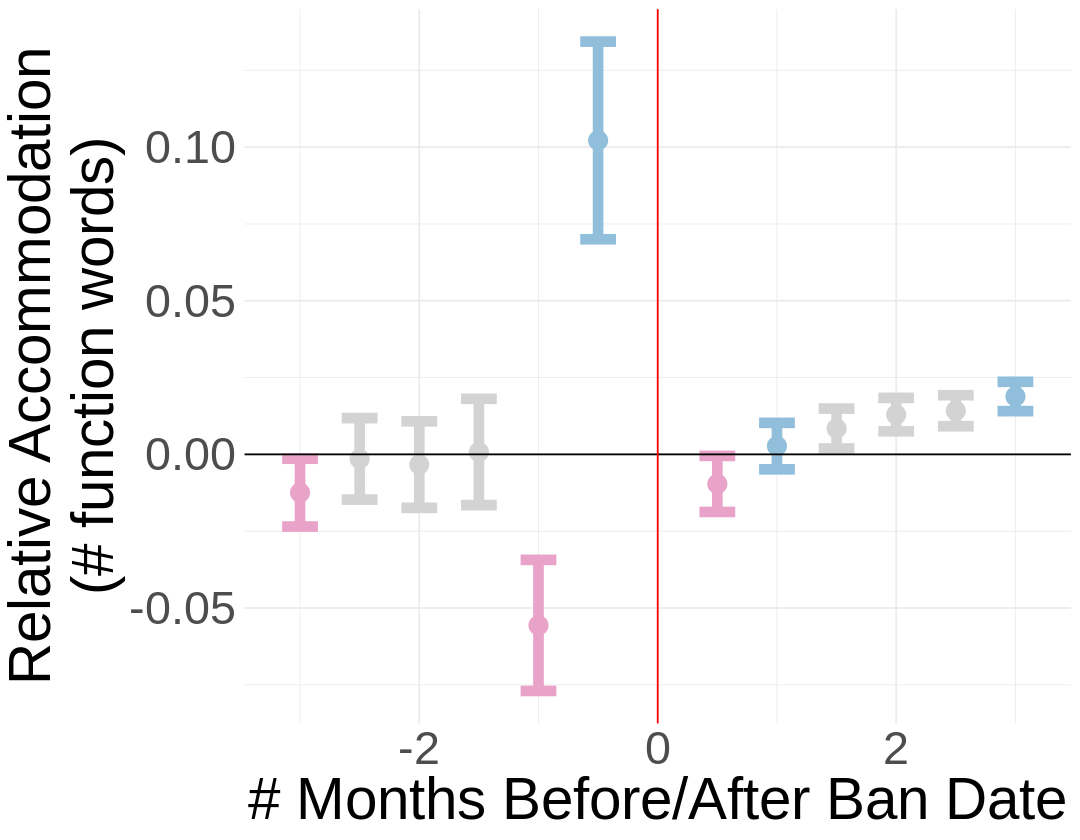

In [76]:
func_df = fread(paste0(data_dir,'function_migration.csv'))
options(repr.plot.width = 9, repr.plot.height = 7)
ggplot(func_df, aes(x = time, y = LSM, ymin = lo, ymax = hi
                    , color=factor(significance)
                   )) +
    geom_point(size = 5) +
    geom_errorbar(size = 3, width = 0.3) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0, color='red') +
    scale_color_manual(values = c('#91bfdb','lightgrey','#e9a3c9')) +
    labs(x='# Months Before/After Ban Date', y='Relative Accommodation\n(# function words)') +
    theme_minimal() +
    theme(legend.position='none',
          text = element_text(size=35))
ggsave(paste0(plot_dir,'function_migration.pdf'), width = 9, height = 7)

In [69]:
n = c('num_markers', 'parent_num_markers', 'formality', 'parent_formality', 'timing', 'type',
      'depth', 'num_tokens', 'parent_num_tokens', 'subreddit', 'author')
m <- c()
b <- c()
lo <- c()
hi <- c()
p <- c()
for(x in c(0.5,1,1.5,2,2.5,3)){
    sub1 = month_before_banned %>% 
            filter(banned_utc - created_utc <= 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub2 = migrated %>% 
            filter(author %in% sub1$author, 
                   abs(first_post_utc - banned_utc) < 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub1 = sub1 %>% filter(author %in% sub2$author)
    sub3 = banned_users_elsewhere %>% 
            filter(author %in% sub1$author,
                   abs(banned_utc - created_utc) <= 60 * 60 * 24 * 30 * x) %>% as.data.frame
    sub1 = sub1 %>% filter(author %in% sub3$author)
    sub2 = sub2 %>% filter(author %in% sub1$author)
    message(paste(Sys.time(),x,nrow(sub1),nrow(sub2),nrow(sub3)))
    
    sub <- rbind(sub1[,n], sub2[,n], sub3[,n]) %>% 
                mutate(type = relevel(factor(type),'Elsewhere')) %>%
                group_by(author) %>%
                mutate(author_re = ifelse(n()<7,'Other',author)) %>% ungroup() %>%
                mutate(style = formality,
                       parent_style = parent_formality)

    mod <- lm(style ~ parent_style * type + 
                    num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'Before Ban'))
    ci1 <- confint(mod)
    ci1 <- ci1[nrow(ci1),]
    m <- c(m, -x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci1[1]))
    hi <- c(hi, unlist(ci1[2]))

    mod <- lm(style ~ parent_style * type + 
                    num_tokens + parent_num_tokens + depth, 
                sub %>% filter(timing == 'After Ban'))
    ci2 <- confint(mod)
    ci2 <- ci2[nrow(ci2),]
    m <- c(m, x)
    b <- c(b, unname(mod$coefficients[length(mod$coefficients)]))
    lo <- c(lo, unlist(ci2[1]))
    hi <- c(hi, unlist(ci2[2]))
    
    p <- c(p, ifelse(ci1[2]<ci2[1], 1, ifelse(ci2[2]<ci1[1], -1, 0)))
    p <- c(p, ifelse(ci1[2]<ci2[1], -1, ifelse(ci2[2]<ci1[1], 1, 0)))
}
form_df = data.frame(time=m, LSM=b, lo=lo, hi=hi, significance=p)
fwrite(form_df, paste0(data_dir,'formality_migration.csv'), row.names=F)

2023-06-15 17:59:11 0.5 513 3736 4168

2023-06-15 17:59:11 1 1135 5835 7768

2023-06-15 17:59:11 1.5 1576 7080 9999

2023-06-15 17:59:12 2 1802 8512 12029

2023-06-15 17:59:12 2.5 1977 9529 14054

2023-06-15 17:59:12 3 2205 10717 16391



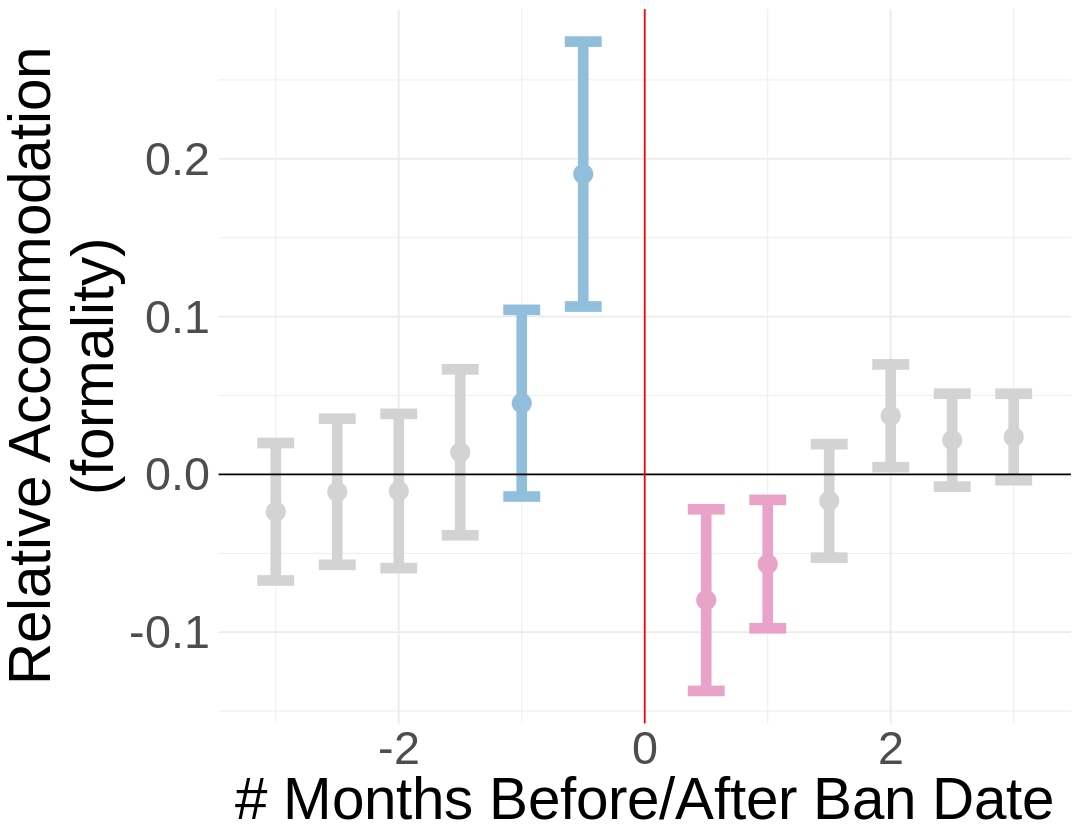

In [77]:
form_df = fread(paste0(data_dir,'formality_migration.csv'))
options(repr.plot.width = 9, repr.plot.height = 7)
ggplot(form_df, aes(x = time, y = LSM, ymin = lo, ymax = hi
                    , color=factor(significance)
                   )) +
    geom_point(size = 5) +
    geom_errorbar(size = 3, width = 0.3) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0, color='red') +
    scale_color_manual(values = c('#91bfdb','lightgrey','#e9a3c9')) +
    labs(x='# Months Before/After Ban Date', y='Relative Accommodation\n(formality)') +
    theme_minimal() +
    theme(legend.position='none',
          text = element_text(size=35))
ggsave(paste0(plot_dir,'formality_migration.pdf'), width = 9, height = 7)